In [1]:
import pandas as pd
import os
import zipfile
import torch

In [30]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [31]:
base_dir = "./mammals_subset"
train_dir = os.path.join(base_dir, 'train')
validation_dir =os.path.join(base_dir, 'val')
# test_dir = os.path.join(base_dir, 'test')

In [29]:
import os
from pathlib import Path
from warnings import filterwarnings

import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

filterwarnings('ignore')
print(tf.__version__)

2.11.0


In [7]:
direc = Path("./mammals_subset")
filepaths = list(direc.glob(r'**/*.jpg'))
Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))


filepaths = pd.Series(filepaths, name='FilePaths').astype(str)
Labels = pd.Series(Labels, name='Labels').astype(str)


img_df = pd.merge(filepaths, Labels, right_index=True, left_index=True)

img_df = img_df[ img_df['Labels'].apply(lambda x: x[-2:]!='GT') ]

#Resampling it
img_df = img_df.sample(frac = 1).reset_index(drop=True)
img_df.head()

,FilePaths,Labels
0,mammals_subset/train/Cervidae/54312584-a70a-42...,Cervidae
1,mammals_subset/train/Cervidae/a507f9d0-f343-43...,Cervidae
2,mammals_subset/train/Leporidae/8649e559-8db5-4...,Leporidae
3,mammals_subset/train/Leporidae/8758d2a7-efc9-4...,Leporidae
4,mammals_subset/train/Cervidae/7bbdb8be-4f99-46...,Cervidae


In [9]:
import PIL
from PIL import Image, ImageFile
from PIL import UnidentifiedImageError

PIL.ImageFile.LOAD_TRUNCATED_IMAGES = True

for img_p in img_df.FilePaths:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_df.loc[img_df['FilePaths'] == img_p].index)
            img_df = img_df.drop(img_df.loc[img_df['FilePaths'] == img_p].index).reset_index()
            print(img_p)

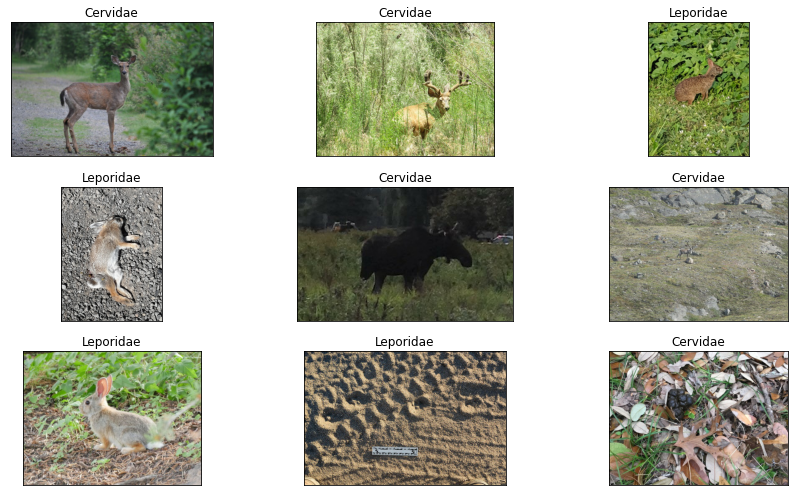

In [10]:
# Let's look at some of the images
import matplotlib.pyplot as plt
import seaborn as sns

f, a = plt.subplots(nrows=3, ncols=3,figsize=(13, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(a.flat):
    ax.imshow(plt.imread(img_df.FilePaths[i]))
    ax.set_title(img_df.Labels[i])
    
plt.tight_layout()
plt.show()

In [11]:
print(f" Number of Rows: {img_df.shape[0]} \n Number of Columns: {img_df.shape[1]} ")

 Number of Rows: 8028 
 Number of Columns: 2 


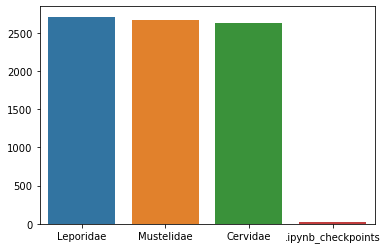

In [12]:
vals = dict(img_df['Labels'].value_counts())
sns.barplot(x=list(vals.keys()), y=list(vals.values()))
plt.show()

In [13]:
X_train, X_test = train_test_split(img_df, test_size=.20)

print(f'Shape of Training Data : ',X_train.shape)
print(f'Shape of Testing Data : ',X_test.shape)

Shape of Training Data :  (6422, 2)
Shape of Testing Data :  (1606, 2)


In [14]:
img_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

img_size = (224, 224)

X_train = img_datagen.flow_from_dataframe(dataframe=X_train, x_col='FilePaths', y_col='Labels',
                                          target_size=img_size, color_mode='rgb', class_mode='categorical', batch_size=32)
X_test = img_datagen.flow_from_dataframe(dataframe=X_test, x_col='FilePaths', y_col='Labels',
                                         target_size=img_size, color_mode='rgb', class_mode='categorical', batch_size=32)

Found 6422 validated image filenames belonging to 4 classes.
Found 1606 validated image filenames belonging to 4 classes.


### Transfer Learning

In [22]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(224,224,3))

In [23]:
model = effnet.output
model = GlobalAveragePooling2D()(model)
model = Dropout(rate=0.5)(model)
model = Dense(9, activation='softmax')(model)
model = Model(inputs=effnet.input, outputs = model)


In [24]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])
print("Model compiled!")

Model compiled!


In [25]:
earlystopping = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=20)

checkpointer = ModelCheckpoint(
    filepath="./mammal.h5",
    verbose=1,
    save_best_only=True,
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", mode="min", verbose=1, patience=10, min_delta=0.0001, factor=0.2
)

In [27]:
# gpu_options = tf.GPUOptions(allow_growth=True)
# session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

AttributeError: module 'tensorflow' has no attribute 'GPUOptions'

In [32]:
history = model.fit(X_train,
                    validation_data=X_test, 
                    epochs=20, batch_size=32,
                    callbacks=[earlystopping, checkpointer, reduce_lr])

Epoch 1/20


ResourceExhaustedError: Graph execution error:

Detected at node 'model_2/block2a_expand_bn/FusedBatchNormV3' defined at (most recent call last):
    File "/anaconda/envs/py38_default/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/anaconda/envs/py38_default/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/traitlets/config/application.py", line 845, in launch_instance
      app.start()
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 612, in start
      self.io_loop.start()
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/anaconda/envs/py38_default/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/anaconda/envs/py38_default/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/anaconda/envs/py38_default/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/tornado/ioloop.py", line 688, in <lambda>
      lambda f: self._run_callback(functools.partial(callback, future))
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/tornado/ioloop.py", line 741, in _run_callback
      ret = callback()
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/tornado/gen.py", line 814, in inner
      self.ctx_run(self.run)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/tornado/gen.py", line 775, in run
      yielded = self.gen.send(value)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 365, in process_one
      yield gen.maybe_future(dispatch(*args))
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 268, in dispatch_shell
      yield gen.maybe_future(handler(stream, idents, msg))
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 543, in execute_request
      self.do_execute(
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 306, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2894, in run_cell
      result = self._run_cell(
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2940, in _run_cell
      return runner(coro)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3165, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3357, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3437, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "<ipython-input-26-4858e82ef4fd>", line 1, in <module>
      history = model.fit(X_train,
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/engine/training.py", line 1023, in train_step
      y_pred = self(x, training=True)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/engine/training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/engine/functional.py", line 511, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/engine/functional.py", line 668, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/layers/normalization/batch_normalization.py", line 866, in call
      outputs = self._fused_batch_norm(inputs, training=training)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/layers/normalization/batch_normalization.py", line 659, in _fused_batch_norm
      output, mean, variance = control_flow_util.smart_cond(
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/utils/control_flow_util.py", line 108, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/layers/normalization/batch_normalization.py", line 633, in _fused_batch_norm_training
      return tf.compat.v1.nn.fused_batch_norm(
Node: 'model_2/block2a_expand_bn/FusedBatchNormV3'
OOM when allocating tensor with shape[32,112,112,96] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_2/block2a_expand_bn/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_56914]

In [ ]:
# Load the best model saved
model = tf.keras.models.load_model("./mammal.h5")
loss, acc = model.evaluate(X_test)
print(f"Test Accuracy: {acc}")
print(f"Test Loss: {loss}")

In [ ]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

epochs = [i for i in range(20)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()